In [1]:
#importing useful libraries
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import math
from types import SimpleNamespace
import seaborn as sns

In [2]:
PARAMETERS = {

    #Knowns for Ground Truth
    'grndAlpha': 10,
    'grndMeanX': 0,
    'grndMeanY': 0,
    'grndSigmaX': 5,
    'grndSigmaY': 5,
    'grndMag': 1000,
    'grndZ': None,

    #General Knowns
    'nDataX': 20,
    'nDataY': 20,
    'nInduX': 10,
    'nInduY': 10,
    'nFineX': 50,
    'nFineY': 50,
    'covLambda': 5000,
    'covL': 2,
    'minX': -5,
    'maxX': 5,
    'minY': -5,
    'maxY': 5,

    #Knowns to be evaluated
    'data': None,
    'grndCoordinates': None,
    'induCoordinates': None,
    'fineCoordinates': None,
    'cInduIndu': None,
    'cInduData': None,
    'cInduFine': None,
    'cInduInduChol': None,
    'cInduInduInv': None,

    # Variables
    'P': float,
    'alpha': float,
    'fIndu': None,

    # Priors
    'ell': 1,
    'sig': 10,
    'fInduMean': 0,
    'alphaShape': 1,
    'alphaScale': 1000,


    # Sampler parameters
    'epsilon': 1e-3,
}

# function to initialize all parameters that are not known or variable
def initialization(parameters):

    #declare variables as object of 
    variables = SimpleNamespace(**parameters)

    # extract knowns
    grndAlpha = variables.grndAlpha
    grndMeanX = variables.grndMeanX
    grndMeanY = variables.grndMeanY
    grndSigmaX = variables.grndSigmaX
    grndSigmaY = variables.grndSigmaY
    grndMag = variables.grndMag
    nDataX = variables.nDataX
    nDataY = variables.nDataY
    covLambda = variables.covLambda
    covL = variables.covL
    epsilon = variables.epsilon
    

    # sample Data
    variables.grndCoordinates, variables.grndZ, variables.data = dataGenerator(
        variables.minX, variables.maxX, variables.minY, variables.maxY,
        nDataX, nDataY, grndMeanX, grndMeanY, grndSigmaX, grndSigmaY, grndMag, grndAlpha)
        
    #define coordinates for Inducing points
    x = np.linspace(variables.minX, variables.maxX, variables.nInduX)
    y = np.linspace(variables.minY, variables.maxY, variables.nInduY)
    xTemp, yTemp = np.meshgrid(x, y)
    X = np.reshape(xTemp, -1)
    Y = np.reshape(yTemp, -1)
    variables.induCoordinates = np.vstack((X, Y)).T
    
    #define coordinates for Fine points
    x = np.linspace(variables.minX, variables.maxX, variables.nFineX)
    y = np.linspace(variables.minY, variables.maxY, variables.nFineY)
    xTemp, yTemp = np.meshgrid(x, y)
    X = np.reshape(xTemp, -1)
    Y = np.reshape(yTemp, -1)
    variables.fineCoordinates = np.vstack((X, Y)).T

    #detrmine Covarince matrices
    variables.cInduIndu = covMat(
        variables.induCoordinates, variables.induCoordinates, covLambda, covL)
    variables.cInduData = covMat(
        variables.induCoordinates, variables.grndCoordinates, covLambda, covL)
    variables.cInduFine = covMat(
        variables.induCoordinates, variables.fineCoordinates, covLambda, covL)
    variables.cInduInduInv = np.linalg.inv(variables.cInduIndu + epsilon*np.eye(variables.nInduX*variables.nInduY))
    variables.cInduInduChol = np.linalg.cholesky(variables.cInduIndu+np.eye(variables.nInduX*variables.nInduY)*epsilon)
    
    #Initial sample for inducing points
    variables.fIndu = np.ones(variables.nInduX*variables.nInduY) * np.mean(variables.data)
    #temp, variables.fIndu, temp = dataGenerator(
    #    variables.minX, variables.maxX, variables.minY, variables.maxY,
    #    variables.nInduX, variables.nInduY, grndMeanX, grndMeanY, grndSigmaX, grndSigmaY, grndMag, grndAlpha)
    
    
    #Initial guess for alpha
    variables.alpha = 10
    
    #Is this next line necassary?
    variables.alphaScale = np.mean(variables.data)/variables.alphaShape

    return variables
    
def curveSampler(variables):

    #necassary variables
    nIndu = variables.nInduX*variables.nInduY
    cInduIndu = variables.cInduIndu
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    alpha = variables.alpha
    data = variables.data
    chol = variables.cInduInduChol
    
    for i in range(np.random.randint(1,1000)):
        # Propose new fIndu
        fInduOld = variables.fIndu
        fInduNew = fInduOld + np.random.randn(nIndu) @ chol * 0.1

        # Calculate probabilities of induced samples
        def probability(fIndu):

            # Prior
            prior = stats.multivariate_normal.logpdf(fIndu.T, mean = np.zeros(nIndu), cov=cInduIndu)
            
            #grnd of data associated with fIndu
            fData = cInduData.T @ cInduInduInv @ fIndu
            
            #Likelihood of that data
            lhood = np.sum(stats.gamma.logpdf(data, a = alpha, scale = fData/alpha))

            prob = lhood + prior

            return prob

        #Probability of old and new function
        pOld = probability(fInduOld)
        pNew = probability(fInduNew)
        
        #Acceptance value
        acc_prob = pNew - pOld

        if np.log(np.random.rand()) < acc_prob:
            variables.fIndu = fInduNew

    return variables

def fineCurveSampler(variables):

    #necassary variables
    nIndu = variables.nInduX*variables.nInduY
    cInduIndu = variables.cInduIndu
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    alpha = variables.alpha
    data = variables.data
    chol = variables.cInduInduChol
    
    for i in range(np.random.randint(1,1000)):
        # Propose new fIndu
        fInduOld = variables.fIndu
        fInduNew = fInduOld + np.random.randn(nIndu) @ chol * 0.05

        # Calculate probabilities of induced samples
        def probability(fIndu):

            # Prior
            prior = stats.multivariate_normal.logpdf(fIndu.T, mean = np.zeros(nIndu), cov=cInduIndu)
            
            #grnd of data associated with fIndu
            fData = cInduData.T @ cInduInduInv @ fIndu
            
            #Likelihood of that data
            lhood = np.sum(stats.gamma.logpdf(data, a = alpha, scale = fData/alpha))

            prob = lhood + prior

            return prob

        #Probability of old and new function
        pOld = probability(fInduOld)
        pNew = probability(fInduNew)
        
        #Acceptance value
        acc_prob = pNew - pOld

        if np.log(np.random.rand()) < acc_prob:
            variables.fIndu = fInduNew

    return variables

def finerCurveSampler(variables):

    #necassary variables
    nIndu = variables.nInduX*variables.nInduY
    cInduIndu = variables.cInduIndu
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    alpha = variables.alpha
    data = variables.data
    chol = variables.cInduInduChol
    
    for i in range(np.random.randint(1,1000)):
        # Propose new fIndu
        fInduOld = variables.fIndu
        fInduNew = fInduOld + np.random.randn(nIndu) @ chol * 0.025

        # Calculate probabilities of induced samples
        def probability(fIndu):

            # Prior
            prior = stats.multivariate_normal.logpdf(fIndu.T, mean = np.zeros(nIndu), cov=cInduIndu)
            
            #grnd of data associated with fIndu
            fData = cInduData.T @ cInduInduInv @ fIndu
            
            #Likelihood of that data
            lhood = np.sum(stats.gamma.logpdf(data, a = alpha, scale = fData/alpha))

            prob = lhood + prior

            return prob

        #Probability of old and new function
        pOld = probability(fInduOld)
        pNew = probability(fInduNew)
        
        #Acceptance value
        acc_prob = pNew - pOld

        if np.log(np.random.rand()) < acc_prob:
            variables.fIndu = fInduNew

    return variables

def alphaSampler(variables):

    # necassary values
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    fIndu = variables.fIndu
    data = variables.data

    #grnd of data associated with fIndu
    fData = cInduData.T @ cInduInduInv @ fIndu

    for i in range(np.random.randint(1,1000)):

        # Propose new alpha
        alphaOld = variables.alpha
        alphaNew = alphaOld + np.random.randn()

        while (alphaNew < 0 or alphaNew > 100):
            alphaNew = alphaOld + np.random.randn()

        # Calculate probabilities of induced samples
        def probability(alpha):

            # Prior
            prior = np.log(0.01)

            #Likelihood of that data
            lhood = np.sum(stats.gamma.logpdf(data, a=alpha, scale=fData/alpha))

            #probability
            prob = lhood + prior

            return prob

        # Acceptance value
        pOld = probability(alphaOld)
        pNew = probability(alphaNew)

        #Acceptance value
        acc_prob = pNew - pOld

        # Update alpha
        if np.log(np.random.rand()) < acc_prob:
            variables.alpha = alphaNew

    return variables

def liklihood(variables):

    # Necassary values
    cInduData = variables.cInduData
    cInduInduInv = variables.cInduInduInv
    fIndu = variables.fIndu
    alpha = variables.alpha
    data = variables.data

    # grnd of data associated with fIndu
    fData = cInduData.T @ cInduInduInv @ fIndu

    # Likelihood
    lhood = np.sum(stats.gamma.logpdf(data, a = alpha, scale = fData/alpha))

    return lhood

'''This method creates synthetic data assuming gamma noise on a function with 2-D gaussian form'''
def dataGenerator(minX, maxX, minY, maxY, lengthx, lengthy, meanx, meany, sigmax, sigmay, mag, alpha):
    
    def function(X, Y, meanx, meany, sigmax, sigmay):
        xterm = np.exp(-((X - meanx)**2)/(2*sigmax**2))
        yterm = np.exp(-((Y - meany)**2)/(2*sigmay**2))
        z = mag*xterm*yterm
        return z

    x = np.linspace(minX, maxX, lengthx)
    y = np.linspace(minY, maxY, lengthy)

    xTemp, yTemp = np.meshgrid(x, y)
    X = np.reshape(xTemp, -1)
    Y = np.reshape(yTemp, -1)

    coordinates = np.vstack((X, Y)).T
    
    zground = function(X, Y, meanx, meany, sigmax, sigmay)

    data = np.random.gamma(alpha, zground/alpha, np.shape(zground))
    return coordinates, zground, data

'''This is a function that returns a covariance matrix between two position vectors
    based on square exponential kernal with parameters covLambda and covL'''    
def covMat(coordinates1, coordinates2, covLambda, covL):
    #Create empty matrix for covariance
    C = np.zeros((len(coordinates1), len(coordinates2)))
    
    #loop over all indecies in covariance matrix
    for i in range(len(coordinates1)):
        for j in range(len(coordinates2)):
            #Calculate distance between points
            dist = math.sqrt((coordinates1[i,0] - coordinates2[j,0])**2 + (coordinates1[i,1] - coordinates2[j,1])**2)
            #Determine each element of covariance matrix
            C[i][j] = (covLambda**2)*(math.exp(((-1)*((dist)**2))/(covL**2)))

    #Return Covariance Matrix
    return C
   

In [3]:
# Initialize variables
variables = initialization(PARAMETERS)

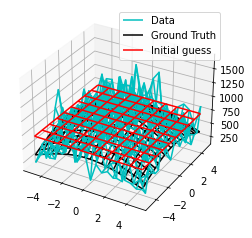

In [4]:
#Plot initial data and ground truth
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#Temp
xTemp = variables.grndCoordinates[:,0].reshape(variables.nDataX, variables.nDataX)
yTemp = variables.grndCoordinates[:,1].reshape(variables.nDataY, variables.nDataY)
zTemp = variables.grndZ.reshape(variables.nDataX, variables.nDataY)
dataTemp = variables.data.reshape(variables.nDataX, variables.nDataY)

xTemp1 = variables.induCoordinates[:,0].reshape(variables.nInduX, variables.nInduY)
yTemp1 = variables.induCoordinates[:,1].reshape(variables.nInduX, variables.nInduY)
induTemp = variables.fIndu.reshape(variables.nInduX, variables.nInduY)

# Plot wireframe.
ax.plot_wireframe(xTemp, yTemp, dataTemp, rstride = 1, cstride = 1, color = 'c', label = 'Data')
ax.plot_wireframe(xTemp, yTemp, zTemp, rstride = 1, cstride = 1, color = 'k', label = 'Ground Truth')
ax.plot_wireframe(xTemp1, yTemp1, induTemp, rstride = 1, cstride = 1, color = 'r', label = 'Initial guess')
plt.legend()

In [5]:

def GibbsSampler(variables):

    alphaVect = []
    alphaVect.append(variables.alpha)

    curveVect = []
    curveVect.append(variables.fIndu)

    pVect = []

    for i in range(100):
        
        variables = alphaSampler(variables)
        alphaVect.append(variables.alpha)

        variables = curveSampler(variables)
        curveVect.append(variables.fIndu)

        variables.P = liklihood(variables)
        pVect.append(variables.P)
    
    for i in range(100):
        
        variables = alphaSampler(variables)
        alphaVect.append(variables.alpha)

        variables = fineCurveSampler(variables)
        curveVect.append(variables.fIndu)

        variables.P = liklihood(variables)
        pVect.append(variables.P)
    '''
    for i in range(50):
        
        variables = alphaSampler(variables)
        alphaVect.append(variables.alpha)

        variables = finerCurveSampler(variables)
        curveVect.append(variables.fIndu)

        variables.P = liklihood(variables)
        pVect.append(variables.P)
    '''
    return variables, alphaVect, curveVect, pVect

variables, alphaVect, curveVect, pVect = GibbsSampler(variables)



In [ ]:
#grnd of data associated with fIndu
MAP = variables.cInduData.T @ variables.cInduInduInv @ curveVect[pVect.index(max(pVect))]
fig = plt.figure()
bx = fig.add_subplot(projection='3d')

#x and y for plotting
xTemp1 = variables.fineCoordinates[:,0].reshape(variables.nFineX, variables.nFineX)
yTemp1 = variables.fineCoordinates[:,1].reshape(variables.nFineY, variables.nFineY)
MAP = MAP.reshape(variables.nDataX, variables.nDataY)

bx.plot_wireframe(xTemp, yTemp, MAP, rstride = 1, cstride = 1, color = 'c', label = 'MAP')
bx.plot_wireframe(xTemp, yTemp, zTemp, rstride = 1, cstride = 1, color = 'k', label = 'Ground Truth')
plt.legend()

In [ ]:
100 * np.abs((alphaVect[pVect.index(max(pVect))] - variables.grndAlpha)/variables.grndAlpha)
pVect.index(max(pVect))

In [ ]:
plt.subplot(2, 1, 1)
plt.contour(xTemp1, yTemp1, MAP)
plt.subplot(2, 1, 2)
plt.contour(xTemp, yTemp, zTemp)

In [ ]:
alphaVect